In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
For easier reading, the code for this notebook is hidden by default.
To toggle the code on/off, click <a href="javascript:code_toggle()">here</a>.''')

# COVID-19 country data
##### Source data: wikipedia.org

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import data_scraper as ds

pd.set_option('display.max_rows', 100)

In [4]:
def get_data(countries, download=False):
    """
    Return dataframe with wikipedia Corona data for countries. Download fresh
    data if download is set to True, otherwise use previously downloaded 
    data in local pickle file.
    """
    if download:
        df = ds.download_data(countries)
        df.to_pickle('wikipedia_data.pickle')
        return df
    return pd.read_pickle('wikipedia_data.pickle')

def date_first_observation(df, cases_or_deaths, row):
    "Return date of first observation (value > 0)."
    column_name = cases_or_deaths + '_' + row.name
    row_index = df[df[column_name] > 0].first_valid_index()
    return df.loc[row_index, 'date']

def max_value(df, cases_or_deaths, row):
    "Return max value for dataframe column"
    column_name = cases_or_deaths + '_' + row.name
    return df[column_name].max()

def max_value_index(df, cases_or_deaths, row):
    "Return index of max value in dataframe column"
    column_name = cases_or_deaths + '_' + row
    return df[column_name].idxmax()

def range_values(df, cases_or_deaths, days, row):
    """
    Return tuple with start and end value of a range from dataframe,
    based on number of days.
    For example if you need the deaths numbers for a country over the
    last 7 days, it will return the most recent observation and the one
    7 days previous to that.
    """
    column_name = cases_or_deaths + '_' + row.name
    end_index = df[column_name].idxmax()
    start_index = end_index - days
    start = wiki_data.loc[start_index, column_name]
    end = wiki_data.loc[end_index, column_name]
    return start, end

def average_growth(df, cases_or_deaths, days, row):
    "Return average growth in cases/deaths over the last x days."
    start, end = range_values(df, cases_or_deaths, days, row)
    return (end - start) / days

def average_growth_rate(df, cases_or_deaths, days, row):
    "Return average growth rate in cases/deaths over the last x days."
    start, end = range_values(df, cases_or_deaths, days, row)
    return ((end / start) ** (1 / days)) - 1

In [5]:
populations = ds.population_table()
all_countries = ds.wiki_shortcodes.keys()
# to download the latest data set download argument to True
wiki_data = get_data(all_countries ,download=False)

In [6]:
# list of all countries with data
all_countries = ds.country_names
# dataframe with all countries
corona = pd.DataFrame(all_countries.items(), columns=['cc', 'country'])
# set index
corona = corona.set_index('cc')
# remove index name
corona.index.name = None
# column with date of first case
corona['first_case'] = corona.apply(
    lambda row: date_first_observation(wiki_data, 'cases', row), axis=1)
# column with date of first death
corona['first_death'] = corona.apply(
    lambda row: date_first_observation(wiki_data, 'deaths', row), axis=1)
# column with total cases
corona['cases_total'] = corona.apply(lambda row: max_value(wiki_data, 'cases', row), axis=1)
# column with total deaths
corona['deaths_total'] = corona.apply(lambda row: max_value(wiki_data, 'deaths', row), axis=1)
# column with cases per million citizens
corona['cases_pM'] = corona.cases_total / pd.Series(populations) * 1000000
# column with deaths per million citizens
corona['deaths_pM'] = corona.deaths_total / pd.Series(populations) * 1000000
# column with average cases over last 5 days
corona['cases_7da'] = corona.apply(
    lambda row: average_growth(wiki_data, 'cases', 7, row), axis=1)
corona['deaths_7da'] = corona.apply(
    lambda row: average_growth(wiki_data, 'deaths', 7, row), axis=1)
corona['deaths_gr1w'] = corona.apply(
    lambda row: average_growth_rate(wiki_data, 'deaths', 7, row), axis=1)
corona['deaths_gr3w'] = corona.apply(
    lambda row: average_growth_rate(wiki_data, 'deaths', 21, row), axis=1)

In [7]:
# sort descending by number of deaths
corona.sort_values('deaths_total', inplace=True, ascending=False)
# column formats
format_dict = {'first_case': '{:%d-%b}', 'first_death': '{:%d-%b}',
               'cases_pM': '{:,.0f}', 'deaths_pM': '{:,.0f}',
               'cases_total': '{:,d}', 'deaths_total': '{:,d}',
               'cases_7da': '{:,.0f}', 'deaths_7da': '{:,.0f}',
               'deaths_gr1w': '{:,.1%}', 'deaths_gr3w': '{:,.1%}'}
corona.style.format(format_dict).hide_index()

country,first_case,first_death,cases_total,deaths_total,cases_pM,deaths_pM,cases_7da,deaths_7da,deaths_gr1w,deaths_gr3w
us,21-Jan,06-Feb,"1,151,625","61,704","3,479",186,"27,292","1,804",3.3%,5.0%
italy,31-Jan,21-Feb,"210,717","28,884","3,485",478,"1,863",320,1.2%,1.8%
uk,31-Jan,05-Mar,"186,599","28,446","2,749",419,"4,823",627,2.4%,4.1%
spain,31-Jan,13-Feb,"247,122","25,264","5,285",540,"2,928",296,1.2%,1.8%
france,25-Feb,25-Feb,"131,287","24,895","2,011",381,959,291,1.2%,2.6%
ny_state,01-Mar,14-Mar,"316,415","19,189","16,265",986,"4,053",318,1.8%,3.5%
belgium,04-Feb,10-Mar,"49,906","7,844","4,306",677,539,107,1.4%,3.8%
germany,24-Feb,09-Mar,"162,496","6,649","1,939",79,"1,189",144,2.4%,4.4%
netherlands,27-Feb,06-Mar,"40,571","5,056","2,368",295,389,83,1.8%,3.0%
canada,25-Jan,09-Mar,"56,714","3,566","1,503",94,"1,623",157,5.4%,8.4%


In [8]:
d7 = corona.loc[:, ['country', 'cases_7da', 'deaths_7da']]
d7 = d7.set_index('country')
d7 = d7.sort_values('deaths_7da')

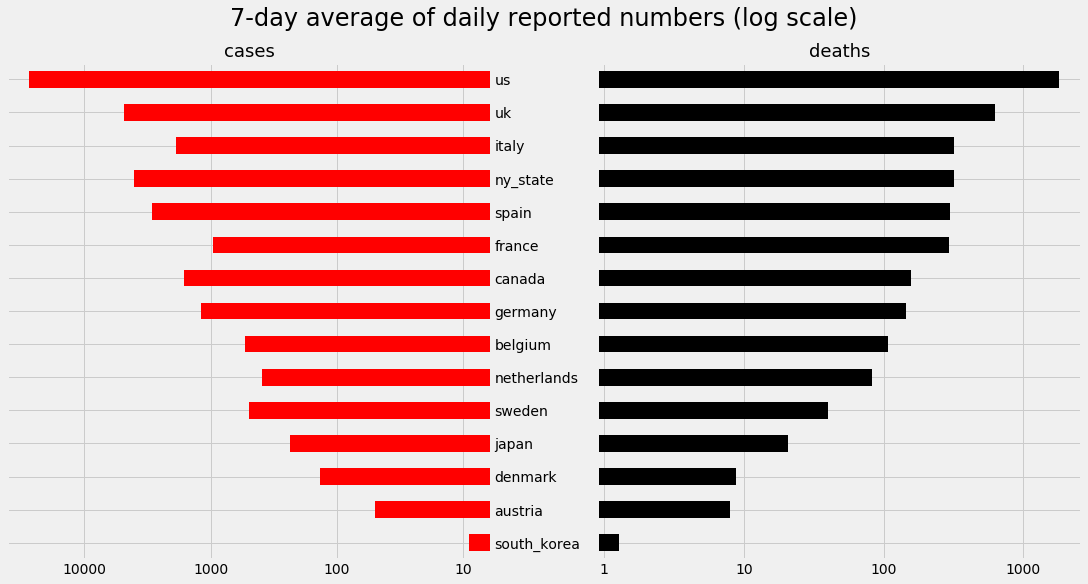

In [9]:
plt.style.use('fivethirtyeight')

fig0, ax0 = plt.subplots(1, 2, figsize=(15, 8), constrained_layout=True)
fig0.suptitle('7-day average of daily reported numbers (log scale)', fontsize=24)

d7.cases_7da.plot(kind='barh', ax=ax0[0], logx=True, sharey=True, color='red')
d7.deaths_7da.plot(kind='barh', ax=ax0[1], logx=True, color='black')

# change labels x-axis from log10 to actual numbers
for axis in [ax0[0].xaxis, ax0[1].xaxis]:
    axis.set_major_formatter(ticker.ScalarFormatter())

ax0[0].invert_xaxis()
ax0[0].yaxis.tick_right()
ax0[0].yaxis.label.set_visible(False)
ax0[0].set_title('cases', fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax0[1].set_title('deaths', fontdict={'fontsize': 18, 'fontweight': 'medium'});

In [10]:
def filter_columns(df, start_string):
    """Return list of columns in dataframe that start with start_string."""
    return [col for col in df.columns if col.startswith(start_string)]


def rename_columns(old_names):
    """Return dictionary with old column names as keys and new ones as values."""
    new_names = {}
    for col in old_names:
        new_names[col] = ds.country_names[col[-2:]]
    return new_names


def start_indices(df, threshold, num_type='int64'):
    """
    For each numeric column in dataframe find index of row where value is
    equal or above threshold. Return as dictionary.
    """
    numeric_columns = df.select_dtypes(num_type).columns
    start_indices = {}
    for col in numeric_columns:
        indices = df[df[col] >= threshold].index
        start_indices[col] = indices[0]
    return start_indices


def growth_table(df, threshold):
    """
    Generate dataframe with cases/deaths by country. Only select rows where total
    is above threshold. Reindex the data for each country before adding to
    dataframe, which enables comparing growth in countries from the same base.
    For example start table from when each country had >= 10 deaths.
    """
    indices = start_indices(df, threshold)
    countries = list(indices.keys())
    base_country = countries[0]
    frame = pd.DataFrame(df.loc[indices[base_country]:, base_country])
    frame = frame.reset_index(drop=True)
    for country in countries[1:]:
        frame2 = pd.DataFrame(df.loc[indices[country]:, country])
        frame2 = frame2.reset_index(drop=True)
        frame = frame.merge(frame2, how='outer', left_index=True, right_index=True)
    # replace remaining 0 with nan (for example, UK often report deaths day later)
    frame = frame.replace(0, np.nan)
    return frame

def country_dataframe(data, shortcode):
    """
    create a dataframe with the COVID-19 data for a specific country
    data(dataframe): source data
    shortcode(string): two-letter code for country
    """
    cols = [data.columns[0]] + [c for c in data.columns if c.endswith(shortcode)]
    df = data.loc[:, cols]
    # rename columns
    df.columns = ['date', 'cases_total', 'deaths_total']
    # filter out rows with 0 cases
    df = df[df.cases_total > 0]
    df = df.reset_index(drop=True)
    # daily cases column
    df.insert(1, 'cases', df.cases_total - df.cases_total.shift(1))
    df.loc[0, 'cases'] = df.loc[0, 'cases_total']
    # daily deaths column
    df.insert(3, 'deaths', df.deaths_total - df.deaths_total.shift(1))
    df.loc[0, 'deaths'] = df.loc[0, 'deaths_total']
    # change column types to integer
    df.loc[:, ['cases', 'deaths']] = df.loc[:, ['cases', 'deaths']].astype('int')
    # growth percentage columns
    df.insert(3, 'cases_gpct', df.cases / (df.cases_total - df.cases))
    df['deaths_gpct'] = df.deaths / (df.deaths_total - df.deaths)
    # growth factor columns
    df.insert(4, 'cases_gf', df.cases / df.cases.shift(1))
    df['deaths_gf'] = df.deaths / df.deaths.shift(1)
    # replace NaN values by 0
    df = df.replace(np.nan, 0)
    # 7-day averages
    df.insert(2, 'cases_7da', df.cases.rolling(window=7).mean())
    df.insert(7, 'deaths_7da', df.deaths.rolling(window=7).mean())
    return df

In [11]:
# lists of required columns
cases_cols = ['date'] + filter_columns(wiki_data, 'cases')
deaths_cols = ['date'] + filter_columns(wiki_data, 'deaths')
# create dataframes
cases_raw = wiki_data.loc[:, cases_cols]
deaths_raw = wiki_data.loc[:, deaths_cols]
# dictionaries with new column names
cases_col_names = rename_columns(cases_raw.columns[1:])
deaths_col_names = rename_columns(deaths_raw.columns[1:])
# rename columns
cases_raw = cases_raw.rename(columns=cases_col_names)
deaths_raw = deaths_raw.rename(columns=deaths_col_names)

In [12]:
cases_start = 100
deaths_start = 10
cases = growth_table(cases_raw, cases_start)
deaths = growth_table(deaths_raw, deaths_start)

In [13]:
max_row = deaths.italy.idxmax()
graph_countries = ['france', 'netherlands', 'uk', 'italy', 'spain', 'us', 'ny_state',
                   'sweden', 'austria', 'belgium', 'germany', 'canada', 'japan']
graph_country_colors = ['xkcd:cyan', 'xkcd:orange', 'xkcd:violet', 'xkcd:olive',
                        'xkcd:golden yellow', 'xkcd:hot pink', 'xkcd:dark pink',
                        'xkcd:blue', 'xkcd:red', 'xkcd:neon green', 'xkcd:black',
                        'xkcd:sea blue', 'xkcd:chestnut']

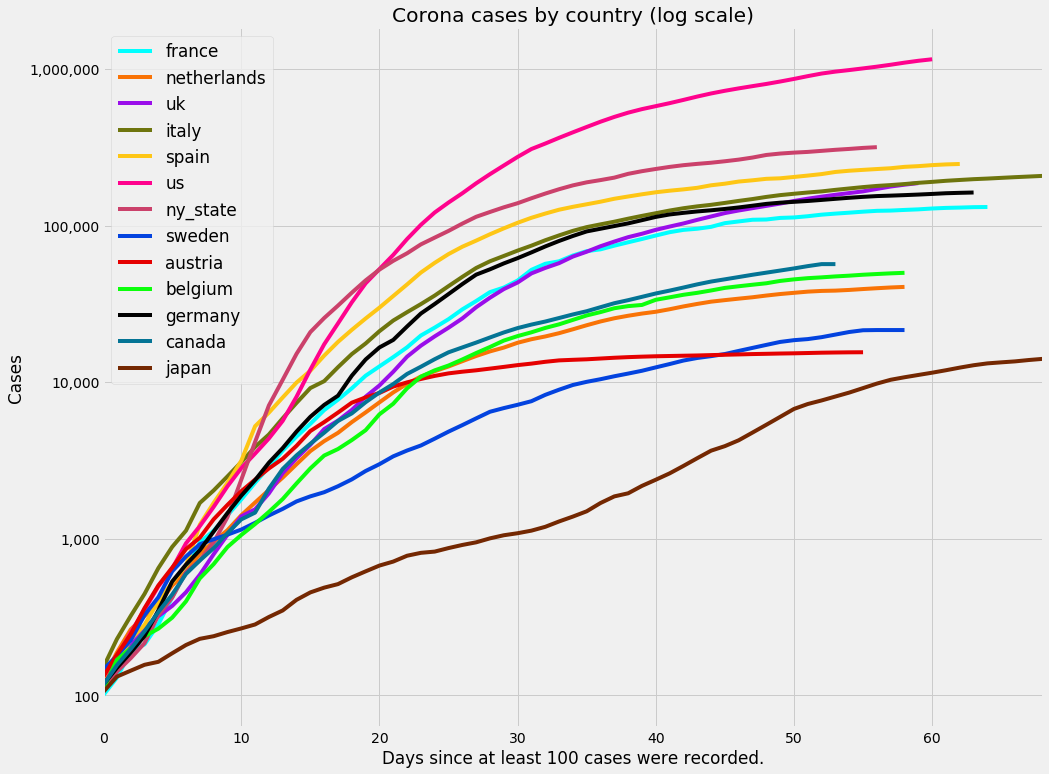

In [14]:
# plt.style.use('fivethirtyeight')

graph_data = cases.loc[: max_row, graph_countries]

fig1, ax1 = plt.subplots(figsize=(15, 12))
ax1.set_prop_cycle(color=graph_country_colors)
graph_data.plot(kind='line', y=graph_data.columns, use_index=True, ax=ax1, logy=True)
x_label_cases = f'Days since at least {cases_start} cases were recorded.'
ax1.set(title='Corona cases by country (log scale)', xlabel=x_label_cases, ylabel='Cases')
ax1.legend(loc='upper left', fontsize='large')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'));

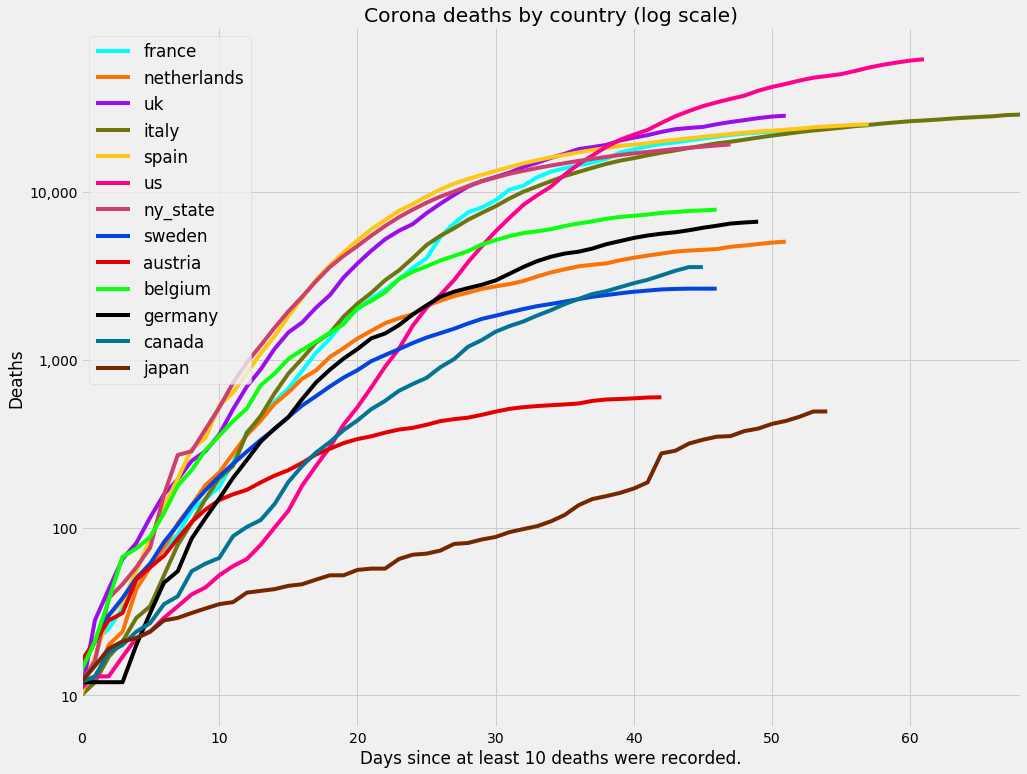

In [15]:
fig2, ax2 = plt.subplots(figsize=(15, 12))
ax2.set_prop_cycle(color=graph_country_colors)
deaths.plot(kind='line', y=graph_data.columns, use_index=True, ax=ax2, logy=True)
x_label_deaths = f'Days since at least {deaths_start} deaths were recorded.'
ax2.set(title='Corona deaths by country (log scale)', xlabel=x_label_deaths, ylabel='Deaths')
ax2.legend(loc='upper left', fontsize='large')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'));

In [16]:
nl = country_dataframe(wiki_data, 'nl')
se = country_dataframe(wiki_data, 'se')
be = country_dataframe(wiki_data, 'be')
de = country_dataframe(wiki_data, 'de')
at = country_dataframe(wiki_data, 'at')
ca = country_dataframe(wiki_data, 'ca')
us = country_dataframe(wiki_data, 'us')
ny = country_dataframe(wiki_data, 'ny')
it = country_dataframe(wiki_data, 'it')
es = country_dataframe(wiki_data, 'es')
fr = country_dataframe(wiki_data, 'fr')
uk = country_dataframe(wiki_data, 'uk')
kr = country_dataframe(wiki_data, 'kr')
jp = country_dataframe(wiki_data, 'jp')

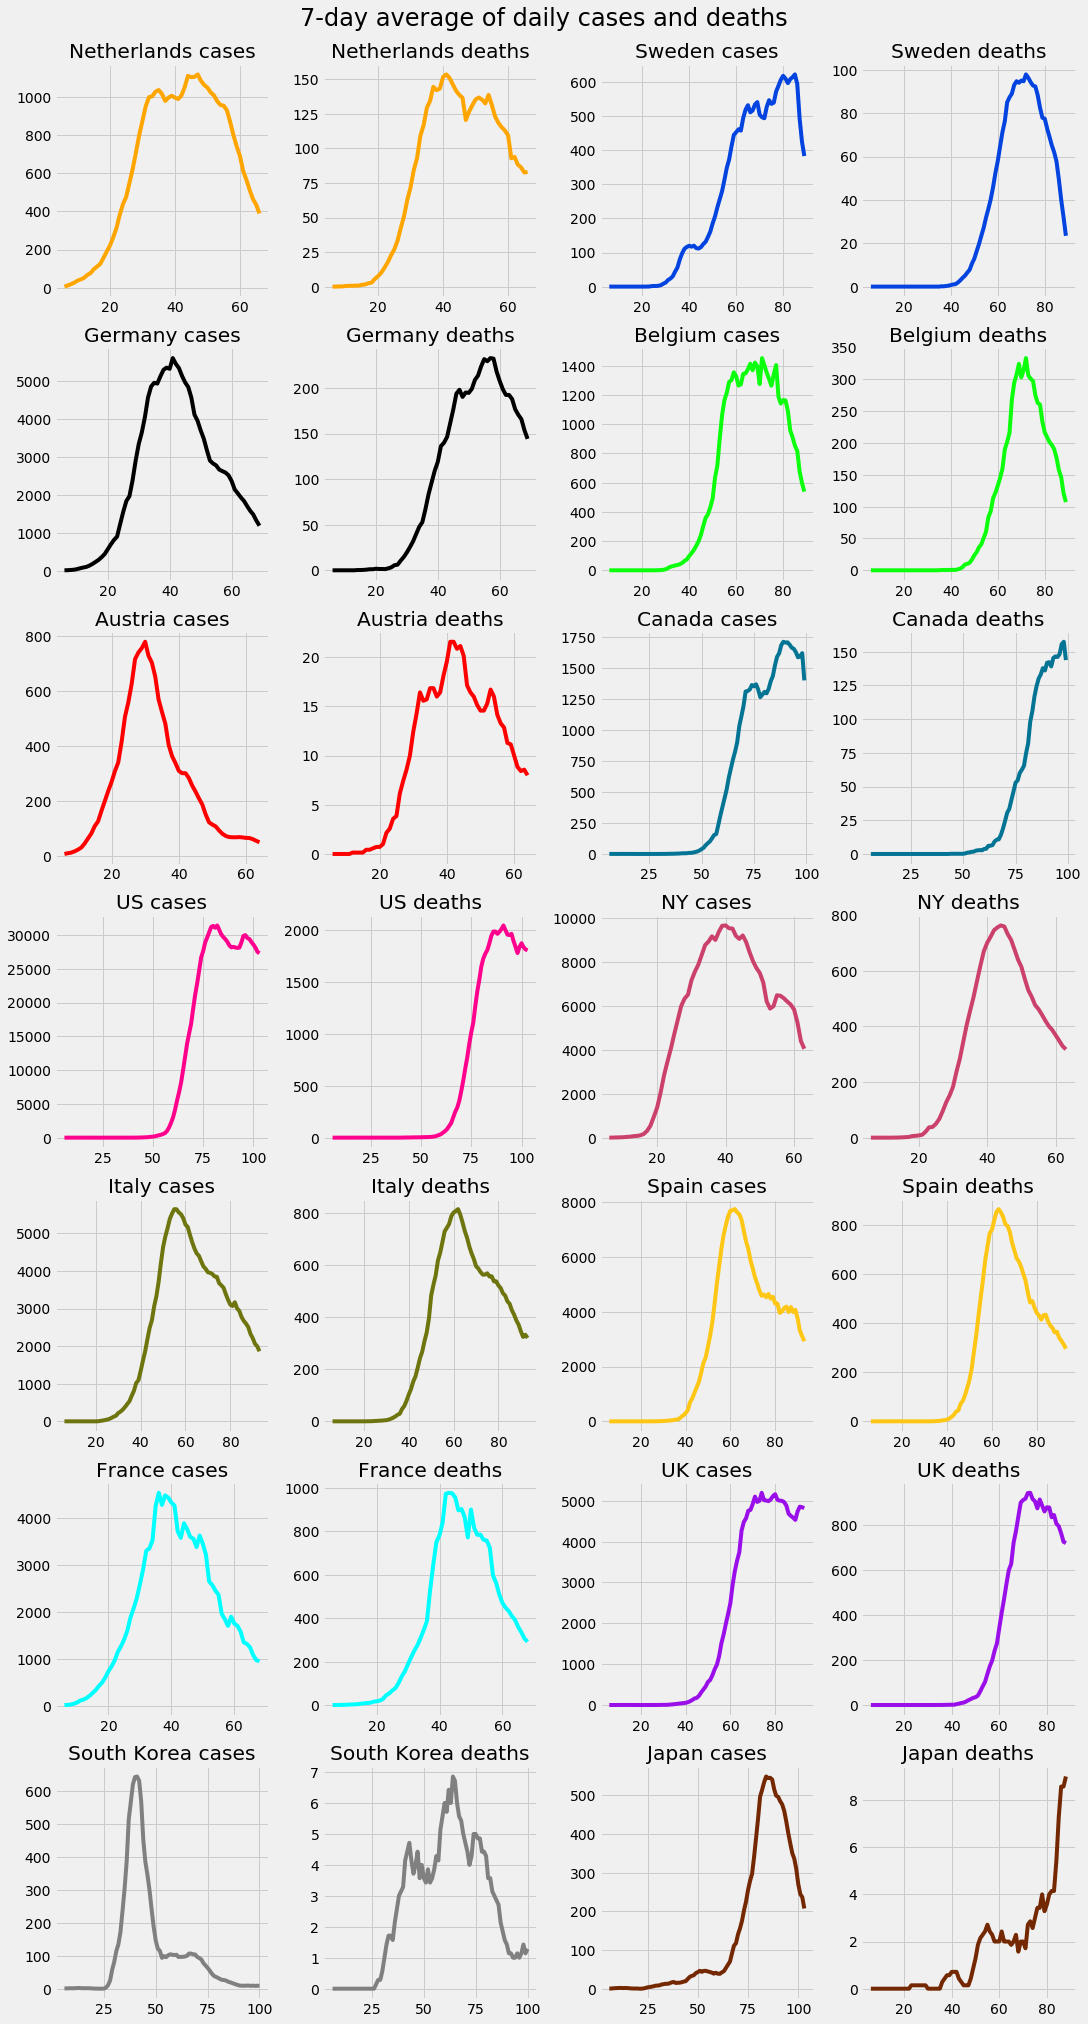

In [17]:
fig3, axes3 = plt.subplots(7, 4, figsize=(15, 28), constrained_layout=True)
fig3.suptitle('7-day average of daily cases and deaths', fontsize=24)

axes3[0, 0].plot(nl.cases_7da, color='orange')
axes3[0, 0].set(title='Netherlands cases')
axes3[0, 1].plot(nl.deaths_7da, color='orange')
axes3[0, 1].set(title='Netherlands deaths')

axes3[0, 2].plot(se.cases_7da, color='xkcd:blue')
axes3[0, 2].set(title='Sweden cases')
axes3[0, 3].plot(se.deaths_7da, color='xkcd:blue')
axes3[0, 3].set(title='Sweden deaths')

axes3[1, 0].plot(de.cases_7da, color='black')
axes3[1, 0].set(title='Germany cases')
axes3[1, 1].plot(de.deaths_7da, color='black')
axes3[1, 1].set(title='Germany deaths')

axes3[1, 2].plot(be.cases_7da, color='xkcd:neon green')
axes3[1, 2].set(title='Belgium cases')
axes3[1, 3].plot(be.deaths_7da, color='xkcd:neon green')
axes3[1, 3].set(title='Belgium deaths')

axes3[2, 0].plot(at.cases_7da, color='red')
axes3[2, 0].set(title='Austria cases')
axes3[2, 1].plot(at.deaths_7da, color='red')
axes3[2, 1].set(title='Austria deaths')

axes3[2, 2].plot(ca.cases_7da, color='xkcd:sea blue')
axes3[2, 2].set(title='Canada cases')
axes3[2, 3].plot(ca.deaths_7da, color='xkcd:sea blue')
axes3[2, 3].set(title='Canada deaths')

axes3[3, 0].plot(us.cases_7da, color='xkcd:hot pink')
axes3[3, 0].set(title='US cases')
axes3[3, 1].plot(us.deaths_7da, color='xkcd:hot pink')
axes3[3, 1].set(title='US deaths')

axes3[3, 2].plot(ny.cases_7da, color='xkcd:dark pink')
axes3[3, 2].set(title='NY cases')
axes3[3, 3].plot(ny.deaths_7da, color='xkcd:dark pink')
axes3[3, 3].set(title='NY deaths')

axes3[4, 0].plot(it.cases_7da, color='xkcd:olive')
axes3[4, 0].set(title='Italy cases')
axes3[4, 1].plot(it.deaths_7da, color='xkcd:olive')
axes3[4, 1].set(title='Italy deaths')

axes3[4, 2].plot(es.cases_7da, color='xkcd:golden yellow')
axes3[4, 2].set(title='Spain cases')
axes3[4, 3].plot(es.deaths_7da, color='xkcd:golden yellow')
axes3[4, 3].set(title='Spain deaths')

axes3[5, 0].plot(fr.cases_7da, color='xkcd:cyan')
axes3[5, 0].set(title='France cases')
axes3[5, 1].plot(fr.deaths_7da, color='xkcd:cyan')
axes3[5, 1].set(title='France deaths')

axes3[5, 2].plot(uk.cases_7da, color='xkcd:violet')
axes3[5, 2].set(title='UK cases')
axes3[5, 3].plot(uk.loc[:88, 'deaths_7da'], color='xkcd:violet')
axes3[5, 3].set(title='UK deaths')

axes3[6, 0].plot(kr.cases_7da, color='grey')
axes3[6, 0].set(title='South Korea cases')
axes3[6, 1].plot(kr.deaths_7da, color='grey')
axes3[6, 1].set(title='South Korea deaths')

axes3[6, 2].plot(jp.cases_7da, color='xkcd:chestnut')
axes3[6, 2].set(title='Japan cases')
axes3[6, 3].plot(jp.loc[:88, 'deaths_7da'], color='xkcd:chestnut')
axes3[6, 3].set(title='Japan deaths')

plt.show()